#### SPAIN MONTHLY INDEXING WITH LSTM AND ARIMA MODEL

In [96]:
#Data wrangling
import numpy as np
import pandas as pd

#Data visualization
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
#Model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
#Metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
#etc
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [97]:
df = pd.read_excel("midterm_project/data/NEW_SPAIN_EPU_INDEX.xlsx", skiprows=1)
df.head()

,Year,Month,Index value
0,1997,1,31.018169
1,1997,2,50.695080
2,1997,3,43.754341
3,1997,4,43.427864
4,1997,5,120.413849


In [98]:
print("Column names:", df.columns)

Column names: Index(['Year', 'Month', 'Index value'], dtype='object')


In [99]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1)); df.head()

,Year,Month,Index value,Date
0,1997,1,31.018169,1997-01-01
1,1997,2,50.695080,1997-02-01
2,1997,3,43.754341,1997-03-01
3,1997,4,43.427864,1997-04-01
4,1997,5,120.413849,1997-05-01


In [100]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df['Date'],
        y=df['Index value'],
        mode='lines',
        name='EPU Index',
        line=dict(color='orange', width=2)
    )
)

fig.update_layout(
    autosize=True,
    title='<b>Economic Policy Uncertainty Index (Spain) - 1997 to 2025</b>',
    xaxis_title='Date',
    yaxis_title='Index Value',
    template='plotly_white',
    hovermode='x unified',
    showlegend=True
)

# Show the plot
fig.show()

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Year         340 non-null    int64         
 1   Month        340 non-null    int64         
 2   Index value  340 non-null    float64       
 3   Date         340 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 10.8 KB


In [102]:
df.describe()

,Year,Month,Index value,Date
count,340.000000,340.000000,340.000000,340
mean,2010.670588,6.452941,112.745058,2011-02-15 02:07:03.529411840
min,1997.000000,1.000000,31.018169,1997-01-01 00:00:00
25%,2004.000000,3.000000,80.984438,2004-01-24 06:00:00
50%,2011.000000,6.000000,108.462086,2011-02-15 00:00:00
75%,2018.000000,9.000000,140.231647,2018-03-08 18:00:00
max,2025.000000,12.000000,261.609741,2025-04-01 00:00:00
std,8.192936,3.465909,40.348093,NaN


In [103]:
df.isna().sum()

Year           0
Month          0
Index value    0
Date           0
dtype: int64

In [104]:
df.isna().value_counts()

Year   Month  Index value  Date 
False  False  False        False    340
Name: count, dtype: int64

In [105]:
for col in df.columns:
    missing_data = df[col].isna().sum()
    missing_per = missing_data /len(df)*100
    print(f"Column {col} has {missing_per}% missing data")

Column Year has 0.0% missing data
Column Month has 0.0% missing data
Column Index value has 0.0% missing data
Column Date has 0.0% missing data


<Axes: >

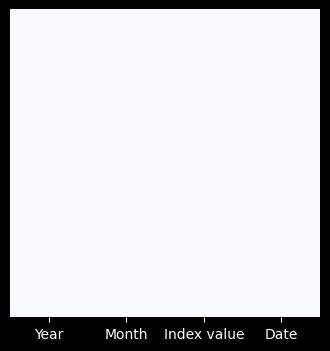

In [106]:
plt.figure(figsize = (4,4))
sns.heatmap(df.isna(), cbar = False, cmap = "Blues", yticklabels = False)

In [107]:
def decompose_ts(df, model='additive', period=12):
    decomposition = seasonal_decompose(df, model=model, period=period)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20,8))

    ax1.plot(decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(decomposition.resid)
    ax4.set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.tight_layout()

decompose_ts(df["Index value"], period=365)



ValueError: x must have 2 complete cycles requires 730 observations. x only has 340 observation(s)

In [108]:
# Check for stationarity using ADF test
# Ho: It is non-stationary
# H1: It is stationary

result = adfuller(df['Index value'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

if result[1] <= 0.05:
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\n\x1b[31mNon-stationary\x1b[0m")


ADF Statistic: -1.5296705531148411
p-value: 0.5187860352255036
Critical Values:
  1%: -3.4503836022181056
  5%: -2.8703653471616826
  10%: -2.571471939191249

Non-stationary


In [109]:
# Check for stationarity using KPSS test
# Ho: It is stationary
# H1: It is non-stationary

stats, p, lags, critical_values = kpss(df['Index value'], 'c', nlags='auto')
print(f'KPSS Statistic: {stats}')
print(f'p-value: {p}')
print(f'lags: {lags}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'  {key}: {value}')

if p < 0.05:
    print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is non-stationary")
else:
    print("Weak evidence against null hypothesis, time series is stationary ")

KPSS Statistic: 2.353930726573175
p-value: 0.01
lags: 10
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is non-stationary


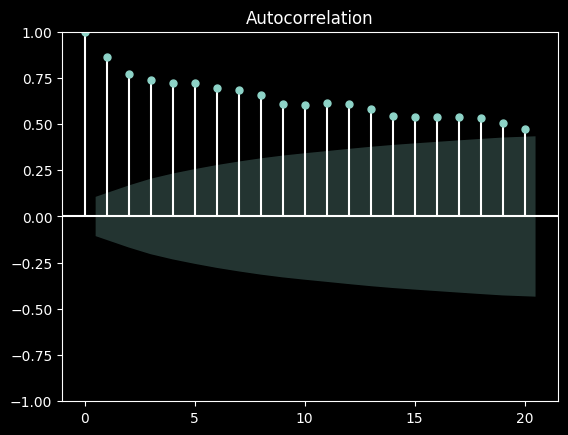

In [111]:


plot_acf(df["Index value"], lags=20);

